In [1]:
import datetime
from geneformer import Classifier

import numpy as np
import torch
import os
import random
import pickle

In [2]:
torch.cuda.is_available()

True

In [3]:
seed_num = 0
random.seed(seed_num)
np.random.seed(seed_num)
seed_val = 42
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

BASE_DIR = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer"
AGGREGATION_LEVEL = "metacell_2"  # Set aggregation level to 'singlecell' for single-cell data
MODEL_VARIANT = "30M"  # Specify the model variant, e.g., "30M" or "95M"
TASK = "dosage_sensitivity"
DATASET = "genecorpus_dosage_sensitivity"

VALID_COMBINATIONS = {
    "disease_classification": ["genecorpus_heart_disease", "cellnexus_blood_disease"],
    "dosage_sensitivity": ["genecorpus_dosage_sensitivity"]
}

assert TASK in VALID_COMBINATIONS, f"Unknown TASK: '{TASK}'"
assert DATASET in VALID_COMBINATIONS[TASK], \
    f"For TASK='{TASK}', DATASET must be one of {VALID_COMBINATIONS[TASK]}, got '{DATASET}'"
                         
if MODEL_VARIANT == "30M":
    GENE_MEDIAN_FILE = os.path.join(BASE_DIR, "Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl")
    TOKEN_DICTIONARY_FILE = os.path.join(BASE_DIR, "Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl")
    ENSEMBL_MAPPING_FILE = os.path.join(BASE_DIR, "Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl")
elif MODEL_VARIANT == "95M":
    GENE_MEDIAN_FILE = os.path.join(BASE_DIR, "Geneformer/geneformer/gene_median_dictionary_gc95M.pkl")
    TOKEN_DICTIONARY_FILE = os.path.join(BASE_DIR, "Geneformer/geneformer/token_dictionary_gc95M.pkl")
    ENSEMBL_MAPPING_FILE = os.path.join(BASE_DIR, "Geneformer/geneformer/ensembl_mapping_dict_gc95M.pkl")
else:
    raise ValueError("MODEL_VARIANT must be either '30M' or '95M'")

# Print the final paths to verify
print(f"GENE_MEDIAN_FILE: {GENE_MEDIAN_FILE}")
print(f"TOKEN_DICTIONARY_FILE: {TOKEN_DICTIONARY_FILE}")
print(f"ENSEMBL_MAPPING_FILE: {ENSEMBL_MAPPING_FILE}")


if TASK == "disease_classification":
    classifier_type = "cell"
elif TASK == "dosage_sensitivity":
    classifier_type = "gene"

else:
    raise ValueError("TASK must be either 'disease_classification' or 'dosage_sensitivity'")


model_version = "V1" # For now it does not do anything, but it is here for future compatibility

 # model_version : str
 #            | To auto-select settings for model version other than current default.
 #            | Current options: V1: models pretrained on ~30M cells, V2: models pretrained on ~104M cells   

output_dir = os.path.join(BASE_DIR, "trained_gene_classification_models", TASK, DATASET, str(MODEL_VARIANT) + "_" + str(AGGREGATION_LEVEL))
os.makedirs(output_dir, exist_ok=True)

GENE_MEDIAN_FILE: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl
TOKEN_DICTIONARY_FILE: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl
ENSEMBL_MAPPING_FILE: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl


In [4]:
DATASET_PATH = os.path.join(BASE_DIR, "datasets", TASK, DATASET)

DATASET_PATH

'/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/datasets/dosage_sensitivity/genecorpus_dosage_sensitivity'

In [5]:
# Example input_data_file: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/blob/main/example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sensitivity_TFs.pickle
with open(os.path.join(DATASET_PATH, "dosage_sensitivity_TFs.pickle"), "rb") as fp:
    gene_class_dict = pickle.load(fp)

In [6]:
DATASET_PATH = os.path.join(BASE_DIR, "datasets", TASK, DATASET)
if TASK == "disease_classification" and DATASET == "genecorpus_heart_disease":
    input_data_file = os.path.join(DATASET_PATH, "human_dcm_hcm_nf.dataset")
    cell_state_dict = {"state_key": "disease", "states": "all"}
    filter_data_dict={"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]}

    # previously balanced splits with prepare_data and validate functions
    # argument attr_to_split set to "individual" and attr_to_balance set to ["disease","lvef","age","sex","length"]
    train_ids = ["1447", "1600", "1462", "1558", "1300", "1508", "1358", "1678", "1561", "1304", "1610", "1430", "1472", "1707", "1726", "1504", "1425", "1617", "1631", "1735", "1582", "1722", "1622", "1630", "1290", "1479", "1371", "1549", "1515"]
    eval_ids = ["1422", "1510", "1539", "1606", "1702"]
    test_ids = ["1437", "1516", "1602", "1685", "1718"]
    
    train_test_id_split_dict = {"attr_key": "individual",
                                "train": train_ids+eval_ids,
                                "test": test_ids}

    train_valid_id_split_dict = {"attr_key": "individual",
                            "train": train_ids,
                            "eval": eval_ids}
    
elif TASK == "dosage_sensitivity" and DATASET == "genecorpus_dosage_sensitivity":
    input_data_file = os.path.join(DATASET_PATH, "gc-30M_sample50k.dataset")

In [7]:
input_data_file

'/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/datasets/dosage_sensitivity/genecorpus_dosage_sensitivity/gc-30M_sample50k.dataset'

In [8]:
# training_args = {
#     "num_train_epochs": 10,
#     "learning_rate": 0.000804,
#     "lr_scheduler_type": "polynomial",
#     "warmup_steps": 1812,
#     "weight_decay":0.258828,
#     "per_device_train_batch_size": 128,
#     "seed": 73,
#     # "load_best_model_at_end": True, # Not required for k-fold cross-validation
#     # "logging_dir": os.path.normpath("D:/geneformer_finetuning/trained_cell_classification_models/disease_classification/genecorpus_heart_disease/30M_metacell_8/250623_geneformer_cellClassifier_genecorpus_heart_disease_test/ksplit1/runs"),
# }

training_args = {
    "num_train_epochs": 10,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 128,
    "seed": 73,
    "evaluation_strategy":"epoch",        # Evaluate every epoch
    "save_strategy":"epoch",              # Save checkpoint every epoch
    "metric_for_best_model":"eval_loss",  # Metric to determine "best" model
    "greater_is_better":False,            # For loss, lower is better
    "load_best_model_at_end":True,        # KEY: Load best model at the end
    "save_total_limit":3,                 # Keep only 3 best checkpoints
    # "logging_dir": os.path.normpath("D:/geneformer_finetuning/trained_cell_classification_models/disease_classification/genecorpus_heart_disease/30M_metacell_8/250623_geneformer_cellClassifier_genecorpus_heart_disease_test/ksplit1/runs"),
}

In [9]:
# OF NOTE: token_dictionary_file must be set to the gc-30M token dictionary if using a 30M series model
# (otherwise the Classifier will use the current default model dictionary)
# 30M token dictionary: https://huggingface.co/ctheodoris/Geneformer/blob/main/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl
cc = Classifier(classifier=classifier_type,
                gene_class_dict = gene_class_dict,
                max_ncells = None, # Set to None for no limit on number of cells
                freeze_layers = 4,
                num_crossval_splits = 5,
                forward_batch_size=200,
                token_dictionary_file = TOKEN_DICTIONARY_FILE,
                nproc=16,
                training_args=training_args)

In [10]:
output_prefix = DATASET + "_test"


In [11]:
# Example input_data_file for 30M model series: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/gene_classification/dosage_sensitive_tfs/gc-30M_sample50k.dataset
cc.prepare_data(input_data_file=input_data_file,
                output_directory=output_dir,
                output_prefix=output_prefix)

In [12]:
output_dir

'/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_gene_classification_models/dosage_sensitivity/genecorpus_dosage_sensitivity/30M_metacell_2'

In [13]:
import os
import glob

# Base path
pretrained_model_path = os.path.join(BASE_DIR, "trained_foundation_models", "models", 
                                   f"30M_AGG{AGGREGATION_LEVEL}_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw")

# Check if final_trained_model subfolder exists
final_model_path = os.path.join(pretrained_model_path, "final_trained_model", AGGREGATION_LEVEL)
final_model_path_empty = False

if os.path.exists(final_model_path) and os.path.isdir(final_model_path):
    # Check if the folder has model files (not just empty)
    model_files = glob.glob(os.path.join(final_model_path, "*.bin")) + \
                  glob.glob(os.path.join(final_model_path, "*.safetensors")) + \
                  glob.glob(os.path.join(final_model_path, "config.json"))
    
    if model_files:
        pretrained_model_path = final_model_path
        print(f"✓ Using final trained model: {pretrained_model_path}")
    else:
        print(f"⚠ Final model folder exists but appears empty: {final_model_path}")
        final_model_path_empty = True
        # Fall through to checkpoint search
else:
    print(f"ℹ Final model folder not found: {final_model_path}")

# If final model not found or empty, find most recent checkpoint
if not (os.path.exists(final_model_path)) or final_model_path_empty:
    # Find all checkpoint folders
    checkpoint_pattern = os.path.join(pretrained_model_path, "checkpoint-*")
    checkpoint_folders = glob.glob(checkpoint_pattern)
    
    if checkpoint_folders:
        # Extract checkpoint numbers and find the highest one
        checkpoint_numbers = []
        for folder in checkpoint_folders:
            folder_name = os.path.basename(folder)
            if folder_name.startswith("checkpoint-"):
                try:
                    checkpoint_num = int(folder_name.split("-")[1])
                    checkpoint_numbers.append((checkpoint_num, folder))
                except ValueError:
                    continue
        
        if checkpoint_numbers:
            # Sort by checkpoint number and get the highest one
            most_recent_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])
            pretrained_model_path = most_recent_checkpoint[1]
            print(f"✓ Using most recent checkpoint: {pretrained_model_path} (step {most_recent_checkpoint[0]})")
        else:
            print(f"❌ No valid checkpoint folders found in: {pretrained_model_path}")
            raise FileNotFoundError(f"No trained model or checkpoints found in {pretrained_model_path}")
    else:
        print(f"❌ No checkpoint folders found in: {pretrained_model_path}")
        raise FileNotFoundError(f"No trained model or checkpoints found in {pretrained_model_path}")

print(f"Final pretrained model path: {pretrained_model_path}")

⚠ Final model folder exists but appears empty: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/final_trained_model/metacell_2
✓ Using most recent checkpoint: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-533301 (step 533301)
Final pretrained model path: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-533301


In [14]:
# 6 layer 30M Geneformer model: https://huggingface.co/ctheodoris/Geneformer/blob/main/gf-6L-30M-i2048/model.safetensors
all_metrics = cc.validate(model_directory=pretrained_model_path,
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix)

0it [00:00, ?it/s]

****** Validation split: 1/5 ******



Some weights of BertForTokenClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-533301 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.729500,0.598352,0.716475,0.714666
2,0.389000,0.302641,0.881955,0.881844
3,0.125700,0.220654,0.919751,0.919716
4,0.029400,0.249514,0.929716,0.929702
5,0.014600,0.273275,0.929138,0.929066
6,0.007300,0.296715,0.932761,0.932746
7,0.005200,0.324849,0.929339,0.929329
8,0.003500,0.338047,0.930622,0.930620
9,0.002200,0.366534,0.931251,0.931250
10,0.001700,0.403581,0.920506,0.920351


/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.i

  0%|          | 0/98 [00:00<?, ?it/s]

****** Validation split: 2/5 ******



Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/32175 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/20672 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/32175 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20672 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/16689 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/16689 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-533301 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.693200,0.595955,0.713991,0.710056
2,0.315400,0.387968,0.827846,0.827839
3,0.093600,0.739190,0.808189,0.808149
4,0.020900,0.918451,0.814691,0.814677
5,0.011100,1.007242,0.817909,0.817894
6,0.006100,1.132073,0.810298,0.810178
7,0.004000,1.064749,0.825172,0.825168
8,0.002600,1.135614,0.825476,0.825476
9,0.001900,1.211961,0.820301,0.820259
10,0.001300,1.241429,0.823845,0.823838


/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.i

  0%|          | 0/104 [00:00<?, ?it/s]

****** Validation split: 3/5 ******



Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/32232 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/21668 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/32232 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21668 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/16596 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/16596 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-533301 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.683100,0.593436,0.726390,0.718734
2,0.332300,0.275349,0.912887,0.912478
3,0.116700,0.159209,0.936532,0.936487
4,0.026600,0.108440,0.956698,0.956659
5,0.014600,0.080376,0.968793,0.968774
6,0.007300,0.097859,0.963654,0.963651
7,0.005100,0.054797,0.981124,0.981109
8,0.003800,0.079177,0.971764,0.971762
9,0.002700,0.095957,0.968696,0.968695
10,0.001700,0.064077,0.979443,0.979427


/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.i

  0%|          | 0/109 [00:00<?, ?it/s]

****** Validation split: 4/5 ******



Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/32450 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/17241 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/32450 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17241 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/19649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/19649 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-533301 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.686400,0.634212,0.635014,0.630720
2,0.305500,0.521582,0.779876,0.777343
3,0.107700,0.666466,0.758439,0.756954
4,0.027400,0.717960,0.786099,0.785506
5,0.014100,0.797324,0.800535,0.800260
6,0.007400,0.924161,0.791326,0.790625
7,0.004900,0.909183,0.808282,0.808034
8,0.002900,1.019458,0.802526,0.802125
9,0.002000,1.050686,0.798482,0.798073
10,0.001900,1.146761,0.790828,0.789893


/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.i

  0%|          | 0/87 [00:00<?, ?it/s]

****** Validation split: 5/5 ******



Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/32185 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/20416 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/32185 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20416 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/18114 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18114 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGmetacell_2_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-533301 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.689200,0.568812,0.768156,0.759863
2,0.320200,0.365822,0.868890,0.861751
3,0.113000,0.356791,0.873949,0.867517
4,0.027800,0.371645,0.897441,0.890760
5,0.013900,0.399603,0.902361,0.896645
6,0.007300,0.413476,0.907535,0.901979
7,0.004600,0.452268,0.910353,0.903938
8,0.002700,0.446660,0.915735,0.910021
9,0.002300,0.489769,0.912132,0.905565
10,0.001400,0.483696,0.914557,0.908843


/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/a1236507/anaconda3/envs/geneformer/lib/python3.11/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.i

  0%|          | 0/103 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

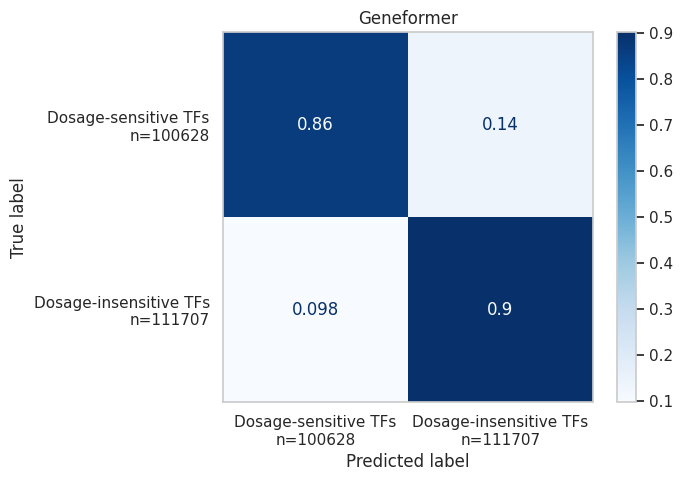

In [15]:
cc.plot_conf_mat(
    conf_mat_dict={"Geneformer": all_metrics["conf_matrix"]},
    output_directory=output_dir,
    output_prefix=output_prefix,
)

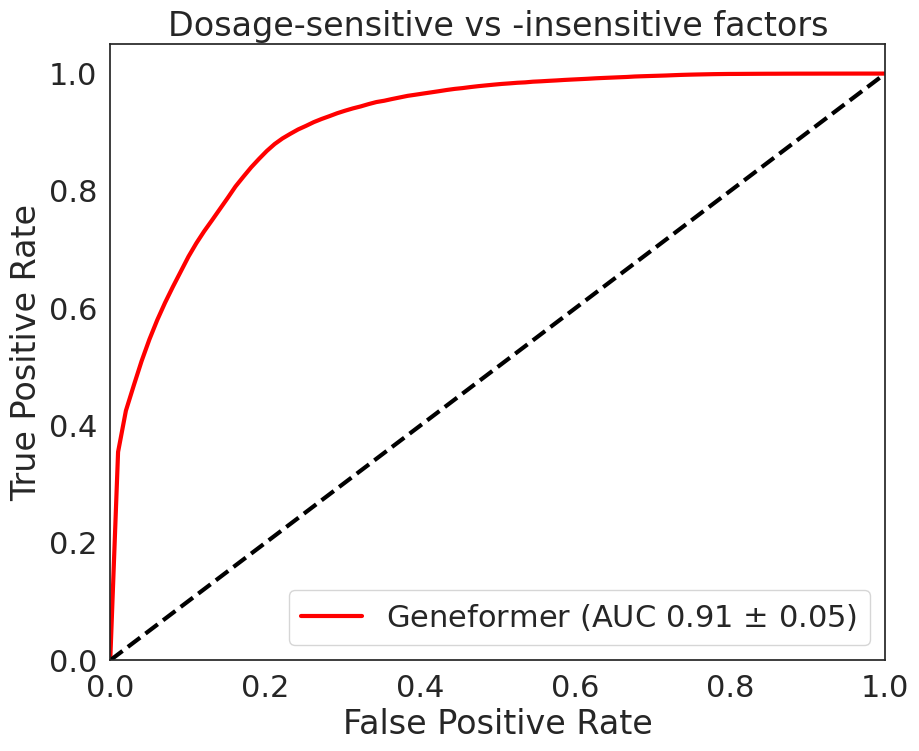

In [16]:
cc.plot_roc(
    roc_metric_dict={"Geneformer": all_metrics["all_roc_metrics"]},
    model_style_dict={"Geneformer": {"color": "red", "linestyle": "-"}},
    title="Dosage-sensitive vs -insensitive factors",
    output_directory=output_dir,
    output_prefix=output_prefix,
)

In [17]:
all_metrics

{'conf_matrix':                         Dosage-sensitive TFs  Dosage-insensitive TFs
 Dosage-sensitive TFs                 86940.0                 13688.0
 Dosage-insensitive TFs               10916.0                100791.0,
 'macro_f1': [np.float64(0.9197156763664855),
  np.float64(0.8278392141553981),
  np.float64(0.9811089477807287),
  np.float64(0.7773433848416131),
  np.float64(0.8675169270789675)],
 'acc': [0.9197513777397519,
  0.8278463947116639,
  0.981123595505618,
  0.7798761706231916,
  0.8739489975053127],
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.35504189, 0.42537724, 0.46824409, 0.50981353,
         0.54683693, 0.5798508 , 0.60944095, 0.63657493, 0.66240541,
         0.68822586, 0.71092107, 0.73129953, 0.74997095, 0.76900175,
         0.78801176, 0.80757207, 0.82412733, 0.84020151, 0.85452854,
         0.86812236, 0.879918  , 0.88946134, 0.89733497, 0.90478489,
         0.91083387, 0.91726901, 0.92262789, 0.92743927, 0.93247489,
         0.93674472, 0.940671